# Statistics and Politics - Deliverable 3: Statistical Modeling
### Arash Tavassoli, April 2019
**Data Science Diploma Program @ BrainStation Vancouver**

---
## 1. Introduction
This practice project involves analyzing the previous United States presidential elections using the available data from 2008, 2012 and 2016 elections.

---
## 2. Objectives
In the first part (Deliverable 1) we started with getting an understanding of the votes and census datasets by examining individual columns. Next, we cleaned the data and dealt with missing values as well as duplicate columns. Eventually, we augmented the data so that each county contains the relative vote share for each party in each election. In the second part (deliverable 2) we performed some statistical analysis on the data. In this part (Deliverable 3) we will use statistical modelling to predict county-level election results.

**Note 1:** For more details on some exploratory data analysis, data cleaning, data augmentation and statistical analysis please refer to the Jupyter Notebooks from Parts 1 and 2.

**Note 2:** In this part we fit different linear models to the dataset and interpret the quality of the models’ fit. We do not use any train_test_split here, and do not perform any variable transformations to ensure linear relationships between independent and dependent variables. This is only to practice evaluating a model’s fit, assessing the relevance and significance of independent features, and comparing the fit quality of different models.

---

## 3. Importing Data From Last Part

Let's start by importing the libraries required for this analysis:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import statsmodels.api as sm

%matplotlib inline

We now import the clean and processed data into a new Pandas dataframe. The csv file was previously exported from the last part where we cleaned and processed the original datasets (Part 1):

In [2]:
df_data_clean = pd.read_csv('clean_data.csv', index_col=[0])

---
## 4. Statistical Modeling

Before starting to fit models to our data let's define some measures that we can use for estimating the quality of each model's fit.

There are different metrics that can be used to evaluate the 'goodness of fit' for each model, and to estimates the quality of the model relative to each of the models that we'll construct in the upcoming sections. In here we use the following as our key metrics for understanding the model's quality of fit (in absense of test data):

**1. Coefficient of Determination ( $\textit{Adjusted} \, R^2$):** 

R-squared ($\, R^2$) represents the proportion of the variance in the dependent variable (the vote share) that is predictable from the independent variables (demographic data). In other words the R-squared value is a measure of how much of the total variance in our dependent variable was explained by our model.

$\textit{Adjusted} \, R^2$ metric is similar to the $R^2$, but it adjusts it to control for the number of parameters included in the model (to account for overfitting):

$$ R_{adj}^2 = 1 - \frac{n-1}{df_{resid}}(1-R^2)$$

**3. Akaike Information Criterion (AIC):**

The Akaike information criterion (AIC) is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. AIC estimates the relative amount of information lost by a given model: the less information a model loses, the higher the quality of that model. In estimating the amount of information lost by a model, AIC deals with the trade-off between the goodness of fit of the model and the simplicity of the model. In other words, AIC deals with both the risk of overfitting and the risk of underfitting.

Suppose that we have a statistical model of some data. Let k be the number of estimated parameters in the model (the number of variables in the model plus the intercept). Let L be the maximum value of the likelihood function for the model. Then the AIC value of the model is the following:

$$ AIC = 2k - 2ln(L)$$

Given a set of candidate models for the data, the preferred model is the one with the minimum AIC value. Thus, AIC rewards goodness of fit (as assessed by the likelihood function), but it also includes a penalty that is an increasing function of the number of estimated parameters. The penalty discourages overfitting, because increasing the number of parameters in the model almost always improves the goodness of the fit (source: [Wikipedia](https://en.wikipedia.org/wiki/Akaike_information_criterion)).

**3. Accuracy:**

For our particular response variable we know that the vote shares in each county defines the winning party in that county. If we were solely interested in model's capability in predicting which political party takes the majority of a county’s votes (winning party) we could convert the true and predicted vote shares into binary classes and define accuracy as ratio of correct predictions to total datapoint (total number of counties). In here, we can also use this measure just to get an understanding of model's capabilities.

It is very important to acknowledge that we will not use a separate test set to calculate this metric and the Accuracy will show the accuracy of the model on already-seen *training data*. This means the model can technically overfit the data and give us a high nominal accuracy, however perform poorly on any unseen data.

**4. P-values for regression coefficients:**

The p-value for each of the regression coefficients define the significance of the relationship between the independent variable (X) and dependent variable (Y), where lower than threshold (here 0.05) p-values mean our data provide enough evidence to reject the null hypothesis that the variable has no correlation with the dependent variable, i.e. the data favor the hypothesis that there is a non-zero correlation between that particular feature and response.

We will also look at models p-value for models F-test *( P( F-statistic ) )* which evaluates the significance of the entire regression model, as a whole.

We can now start fitting models!

### 4.1. Linear Regression to Predict 2008 Relative Vote Share of Republicans

We start the statistical modeling by fitting a linear regression model that predicts the 2008 relative vote share of the Republican party within a county using the county-level demographic data.

The first model will use all available demographic data, which includes all features except for the following (we will call this the *base* model):

- The vote shares (`Democrats 08 (ratio)`, `Republicans 08 (ratio)`, `Democrats 12 (ratio)`, `Republicans 12 (ratio)`,`Democrats 16 (ratio)` and `Republicans 16 (ratio)`) as they are the response variables (or their complementary portions)
- The `Fips`, `County` and `Precincts` as they are deemed irrelevant for this analysis

We also create dummy variables for the `State` variable as it is a categorical feature.

For each model the independent variables are the demographic data assiciated with each uniquely identified county and the response variable is the Republican vote share for each election.

Let's start with a base linear model including all relevant features:

In [3]:
columns_to_exclude = ['Fips', 'County', 'Precincts', 
                      'Democrats 08 (ratio)', 'Republicans 08 (ratio)', 'Democrats 12 (ratio)',
                      'Republicans 12 (ratio)','Democrats 16 (ratio)', 'Republicans 16 (ratio)']

X = df_data_clean.drop(columns_to_exclude, axis = 1)
X = pd.get_dummies(X)     # Adding dummy variables for State (categorical)
X = sm.add_constant(X)    # Adding the constant as required by statsmodel

y = df_data_clean['Republicans 08 (ratio)']

myregression = sm.OLS(y,X).fit()

prediction = myregression.predict(X)

prediction_binary = np.where(prediction >= 0.5, 1,0)
y_binary = np.where(y >= 0.5, 1,0)
total_correct = np.sum(prediction_binary == y_binary)
print("Accuracy:", total_correct / len(y))

print("The AIC estimator is:", myregression.aic)

# See if any predicted negative values:
print("There are", prediction[prediction<0].count(), "predicted value(s) less than 0")
# See if any predicted values above 1:
print("There are", prediction[prediction>1].count(), "predicted value(s) above 1")

display(myregression.summary())

Accuracy: 0.8771309102605339
The AIC estimator is: -8100.250398329863
There are 0 predicted value(s) less than 0
There are 0 predicted value(s) above 1


/Users/Arash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Republicans 08 (ratio)   R-squared:                       0.793
Model:                                OLS   Adj. R-squared:                  0.787
Method:                     Least Squares   F-statistic:                     128.4
Date:                    Fri, 26 Apr 2019   Prob (F-statistic):               0.00
Time:                            19:26:12   Log-Likelihood:                 4141.1
No. Observations:                    3109   AIC:                            -8100.
Df Residuals:                        3018   BIC:                            -7550.
Df Model:                              90                                         
Covariance Type:                nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                         -0.7125      3.270     -0.218      0.828      -7.125       5.700
Votes                                                      -1.581e-07   5.34e-08     -2.960      0.003   -2.63e-07   -5.34e-08
Less Than High School Diploma                                  0.0007      0.000      1.700      0.089      -0.000       0.002
At Least Bachelors's Degree                                   -0.0014      0.001     -2.429      0.015      -0.003      -0.000
Graduate Degree                                               -0.0090      0.001     -8.452      0.000      -0.011      -0.007
School Enrollment                                              0.0005      0.000      1.601      0.110      -0.000       0.001
Median Earnings 2010                                       -1.151e-06   5.21e-07     -2.210      0.027   -2.17e-06    -1.3e-07
White (Not Latino) Population                                  0.0076      0.024      0.313      0.754      -0.040       0.055
African American Population                                    0.0003      0.024      0.012      0.990      -0.047       0.048
Native American Population                                     0.0025      0.024      0.104      0.917      -0.045       0.050
Asian American Population                                      0.0006      0.024      0.023      0.981      -0.047       0.048
Other Race or Races                                           -0.0058      0.024     -0.242      0.809      -0.053       0.042
Latino Population                                              0.0015      0.024      0.062      0.950      -0.046       0.049
Children Under 6 Living in Poverty                         -1.187e-05      0.000     -0.052      0.958      -0.000       0.000
Adults 65 and Older Living in Poverty                          0.0002      0.000      0.517      0.606      -0.001       0.001
Total Population                                            4.759e-08   1.81e-08      2.623      0.009     1.2e-08    8.32e-08
Preschool.Enrollment.Ratio.enrolled.ages.3.and.4              -0.0004   9.74e-05     -3.902      0.000      -0.001      -0.000
Poverty.Rate.below.federal.poverty.threshold                  -0.0046      0.001     -5.618      0.000      -0.006      -0.003
Gini.Coefficient                                               0.1157      0.050      2.297      0.022       0.017       0.214
Child.Poverty.living.in.families.below.the.poverty.line        0.0017      0.000      3.508      0.000       0.001       0.003
Management.professional.and.related.occupations                0.0133      0.023      0.571      0.568      -0.032    

With all independent variables included in the model here's what we've got:

- **Number of independent variables:** 91
- **R-squared:** 0.793
- **Accuracy:** 0.877
- **AIC:** -8100.2
- **P(F-statistic):** 0.00

The F-test of the overall significance compares the model with no predictors (an intercept-only model) to the currently fitted model, i.e. the null hypothesis that the fit of the intercept-only model and current model are equal, and alternative hypothesis that the fit of the intercept-only model is significantly reduced compared to current model. With P(F-statistic) being lower than the 0.05 threshold we can reject the null-hypothesis and conclude that this model, as a whole, provides a better fit than the intercept-only model.

But looking at the summary table for the OLS regression we find a lot of independent variables having large p-values. A low P-value for a independent variable means that the particular independent variable significantly improves the fit of the model. At the same time, looking at individual p-values can be misleading because if we have variables that are highly collinear we will get large p-values. However, this does not mean the variables are necessarily useless. In this case the regression summary also gives a warning that there might be strong multicollinearity between the X variables.

From part 2 of this project we remember that the `White (Not Latino) Population` column had a relatively high Pearson correlation coefficient with the response variable (vote share) but here we see a very high p-value for the regression coefficient associated with this variable (0.942). Let's have a quick look at the correlation between this variable and the rest of the independent variables:

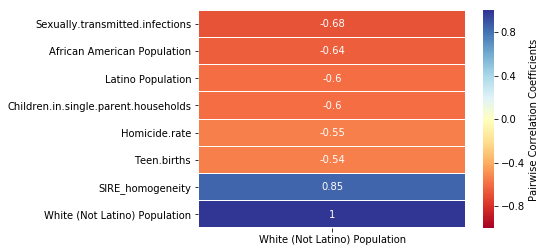

In [4]:
X = df_data_clean.drop(columns_to_exclude, axis = 1)

# Finding the Pearson correlation coefficient between 
# the 'White (Not Latino) Population' and all other variables:
white_corr = X.corrwith(X['White (Not Latino) Population']).sort_values()

# Filtering only the ones that yield a correlation coeff of > 0.5
white_corr = white_corr[np.abs(white_corr)>0.5]

# Plotting on a heatmap:
sns.heatmap(pd.DataFrame(white_corr, columns = ['White (Not Latino) Population']), 
            annot = True,
            cmap = 'RdYlBu',
            linewidths = .1, 
            vmin = -1, vmax = 1, 
            cbar_kws = {'label': 'Pairwise Correlation Coefficients'});

As expected, this variable appears to have high correlation coefficient with multiple variables, therefore the high p-value might be due to variable's high collinearity and the multicollinearity in multiple regression.

At this time we will not spend much more time on dealing with the collinearity issue but will aknowledge that this is something that must be considered for proper modeling of the data.

Let's see if we can do some feature selection and fit a better model.

#### Model Selection and Model Parsimony

A parsimonious model is a model that accomplishes a desired level of explanation or prediction with as few predictor variables as possible. 

One approach to get a parsimonious model is to use individual variables' p-values. In this approach we start with full model and drop the variable that has the highest p-value. Then we re-fit the model and repeat this cycle until all our variables left in the model are significant (p-value < 0.05 for individual independent variables). This approach leads us to a parsimonious model, however it again does not account for multicollinearity in the X data. Knowling this, we still give this approach a try:

In [13]:
# Starting with all columns except the following:
columns_to_exclude = ['Fips', 'County', 'Precincts', 
                      'Democrats 08 (ratio)', 'Republicans 08 (ratio)', 'Democrats 12 (ratio)',
                      'Republicans 12 (ratio)','Democrats 16 (ratio)', 'Republicans 16 (ratio)']

X = df_data_clean.drop(columns_to_exclude, axis = 1)
X_temp = pd.get_dummies(X)

y = df_data_clean['Republicans 08 (ratio)']

p_value_condition = True


# dropping features until we only have features for which we get p < 0.05:
while p_value_condition:
    
    X = sm.add_constant(X_temp)
    
    myregression = sm.OLS(y,X).fit()

    # Droping the feature with highest p-value:
    p_values = myregression.pvalues
    p_values.drop(p_values.head(1).index, inplace = True)     # drop the constant
    sorted_p_values = p_values.sort_values()
    sorted_p_values.drop(sorted_p_values.tail(1).index, inplace = True)      # Drop the highest p
    X_temp = X[sorted_p_values.index.tolist()]

    p_value_condition = p_values[p_values.values > 0.05].any()

prediction = myregression.predict(X)

prediction_binary = np.where(prediction >= 0.5, 1,0)
y_binary = np.where(y >= 0.5, 1,0)
total_correct = np.sum(prediction_binary == y_binary)
print("Accuracy:", total_correct / len(y))

print("The AIC estimator is:", myregression.aic)

# See if any predicted negative values:
print("There are", prediction[prediction<0].count(), "predicted value(s) less than 0")
# See if any predicted values above 1:
print("There are", prediction[prediction>1].count(), "predicted value(s) above 1")

display(myregression.summary())

Accuracy: 0.8735927951109682
The AIC estimator is: -8120.055072591062
There are 0 predicted value(s) less than 0
There are 0 predicted value(s) above 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Republicans 08 (ratio)   R-squared:                       0.791
Model:                                OLS   Adj. R-squared:                  0.787
Method:                     Least Squares   F-statistic:                     172.0
Date:                    Fri, 26 Apr 2019   Prob (F-statistic):               0.00
Time:                            19:46:24   Log-Likelihood:                 4128.0
No. Observations:                    3109   AIC:                            -8120.
Df Residuals:                        3041   BIC:                            -7709.
Df Model:                              67                                         
Covariance Type:                nonrobust                                         
==============================================================================================================================
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          0.2090      0.035      6.046      0.000       0.141       0.277
White (Not Latino) Population                                  0.0076      0.000     36.375      0.000       0.007       0.008
State_Iowa                                                    -0.1601      0.008    -20.335      0.000      -0.176      -0.145
State_Wisconsin                                               -0.1683      0.009    -19.179      0.000      -0.186      -0.151
State_Texas                                                    0.1258      0.007     19.311      0.000       0.113       0.139
State_Georgia                                                  0.1173      0.007     17.370      0.000       0.104       0.130
State_Minnesota                                               -0.1373      0.008    -16.844      0.000      -0.153      -0.121
SIRE_homogeneity                                              -0.2480      0.016    -15.254      0.000      -0.280      -0.216
State_Vermont                                                 -0.2470      0.018    -13.760      0.000      -0.282      -0.212
State_Alabama                                                  0.1222      0.009     13.222      0.000       0.104       0.140
State_Mississippi                                              0.1225      0.009     13.136      0.000       0.104       0.141
State_Louisiana                                                0.1207      0.010     12.484      0.000       0.102       0.140
Farming.fishing.and.forestry.occupations                       0.0075      0.001     11.857      0.000       0.006       0.009
State_North Dakota                                            -0.1206      0.011    -11.416      0.000      -0.141      -0.100
State_Michigan                                                -0.0939      0.008    -11.349      0.000      -0.110      -0.078
Management.professional.and.related.occupations                0.0041      0.000     10.751      0.000       0.003       0.005
State_Illinois                                                -0.0792      0.008    -10.479      0.000      -0.094      -0.064
State_Oklahoma                                                 0.1094      0.011     10.243      0.000       0.088       0.130
State_South Dakota                                            -0.0959      0.010     -9.883      0.000      -0.115      -0.077
State_Maine                                                   -0.1649      0.017     -9.820      0.000      -0.198      -0.132
State_Indiana                                                 -0.0713      0.008     -8.926      0.000      -0.087    

Let's look at the same metrics:

- **Number of independent variables:** 67 (less than base model > good)
- **R-squared:** 0.791 (slightly less than base model > bad)
- **Accuracy:** 0.874 (slightly less than base model > bad)
- **AIC:** -8120.05 (less than base model > good)
- **P(F-statistic):** 0.00

As we can see the R-squared and Acuracy have not shifted in our favor but we already knew that dropping features would not increase, but decrease the R-squared.

But there are two main advantages with this model:

1. Higher AIC value suggesting a 'higher quality' fit (considering the over and under-fitting trade-off)
2. Significance for all included features where all regression coefficients have p-values <0.05. The lower than threshold p-value means our data provide enough evidence to reject the null hypothesis that the variable has no correlation with the dependent variable, i.e. the data favor the hypothesis that there is a non-zero correlation and supports statical significance for all regression coefficients in this case.

### Regularization

As the last effort let's see if regularization would help our model's fit. To keep things simple we try regularization with the base model (that included all features).

Unfortunately the regularized version of statsmodel's Linear Regression does not provide AIC nor R-squared values for the model. So we manually define a function to calculate the R-squared value and also use the binary Accuracy metric to analyze the effect of regularization on the model. We will try L2 regularization on the model (with all features included) and plot the R2 and Accuracy values vs. alpha value (penalty factor):

In [7]:
# Function to calculate R2:
def calc_R2(predicted_y_values, actual_y_values):
    ss_resid = np.sum((predicted_y_values - actual_y_values)**2)
    ss_total = np.sum((actual_y_values - np.mean(actual_y_values))**2)
    return round(1 - ss_resid/ss_total, 4)

In [8]:
columns_to_exclude = ['Fips', 'County', 'Precincts', 
                      'Democrats 08 (ratio)', 'Republicans 08 (ratio)', 'Democrats 12 (ratio)',
                      'Republicans 12 (ratio)','Democrats 16 (ratio)', 'Republicans 16 (ratio)']

X = df_data_clean.drop(columns_to_exclude, axis = 1)
X = pd.get_dummies(X)     # Adding dummy variables for State (categorical)
X = sm.add_constant(X)    # Adding the constant as required by statsmodel

y = df_data_clean['Republicans 08 (ratio)']
y_binary = np.where(y >= 0.5, 1, 0)

accuracy_list = []
R2_list = []
alpha_list = []

# Fitting model with alpha between 0 and 10 and calculating the accuracy
for alpha in np.arange(0, 10, 0.01):
    
    myregression = sm.OLS(y,X).fit_regularized(alpha = alpha, L1_wt = 0)
    
    prediction = myregression.predict(X)
    prediction_binary = np.where(prediction >= 0.5, 1,0)
    
    total_correct = np.sum(prediction_binary == y_binary)
    
    accuracy_list.append(total_correct / len(y))
    R2_list.append(calc_R2(prediction, y))
    alpha_list.append(alpha)

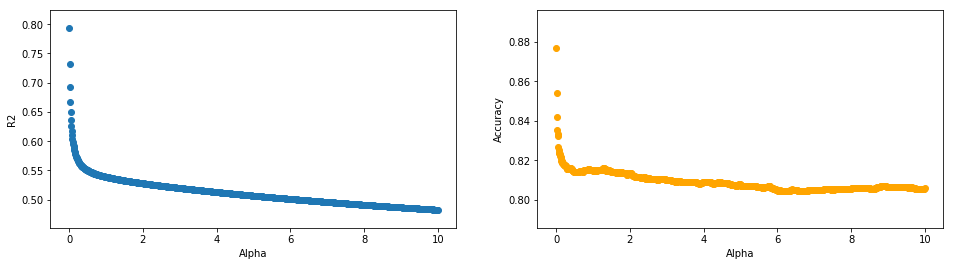

In [9]:
# Plotting the R2 and accuracy values vs. Alpha:
plt.figure(figsize = (16,4))
gridspec.GridSpec(1,2)

plt.subplot2grid((1,2), (0,0))
plt.scatter(alpha_list, R2_list);
plt.xlabel('Alpha');
plt.ylabel('R2');

plt.subplot2grid((1,2), (0,1))
plt.scatter(alpha_list, accuracy_list, color = 'orange');
plt.xlabel('Alpha');
plt.ylabel('Accuracy');

As expected, the R-squared and accuracy values drop as the model gets more agressively penalized for high regression coefficients (higher alpha). But the main thing to remember is that this is the accuracy of the model on the **training** data and not test data. Regularization is used to avoid over-fitting and is expected to increase the acuracy of the model on the unseen **test** data, at the cost of losing accuracy on the training data.

### 4.1. Logistic Regression

Now let's fit a logistic regression model on the same data and see if we get a different performance. 

**Note:** One disadvantage of using linear regression for a response variable like vote share is that, theoretically, linear model may give negative or above 1 values, although we know for sure that our true response values (Y) are strictly between 0 and 1 (although we showed for all cases above that no values >1 or <0 were predicted by the previous linear regression models). This concern is not valid for logistic regression as it always yields predictions between 0-1.

In [10]:
columns_to_exclude = ['State', 'Fips', 'County', 'Precincts', 
                      'Democrats 08 (ratio)', 'Republicans 08 (ratio)', 'Democrats 12 (ratio)',
                      'Republicans 12 (ratio)','Democrats 16 (ratio)', 'Republicans 16 (ratio)']

X = df_data_clean.drop(columns_to_exclude, axis = 1)
X = sm.add_constant(X)    # Adding the constant as required by statsmodel:

y = df_data_clean['Republicans 08 (ratio)']

mylogit = sm.Logit(y, X).fit()

prediction = mylogit.predict(X)

prediction_binary = np.where(mylogit.predict(X) >= 0.5, 1,0)
y_binary = np.where(y >= 0.5, 1,0)

total_correct = np.sum(prediction_binary == y_binary)
print ("Accuracy:", total_correct / len(y))

display(mylogit.summary())

Optimization terminated successfully.
         Current function value: 0.618831
         Iterations 6
Accuracy: 0.8427146992602123


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Logit Regression Results                             
==================================================================================
Dep. Variable:     Republicans 08 (ratio)   No. Observations:                 3109
Model:                              Logit   Df Residuals:                     3067
Method:                               MLE   Df Model:                           41
Date:                    Fri, 26 Apr 2019   Pseudo R-squ.:                 -0.1003
Time:                            19:26:27   Log-Likelihood:                -1923.9
converged:                           True   LL-Null:                       -1748.6
                                            LLR p-value:                     1.000
==============================================================================================================================
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------
const                                                          2.4813    106.241      0.023      0.981    -205.747     210.710
Votes                                                      -1.441e-06   1.61e-06     -0.898      0.369   -4.59e-06    1.71e-06
Less Than High School Diploma                                 -0.0011      0.012     -0.088      0.930      -0.024       0.022
At Least Bachelors's Degree                                   -0.0097      0.018     -0.551      0.582      -0.044       0.025
Graduate Degree                                               -0.0322      0.030     -1.070      0.284      -0.091       0.027
School Enrollment                                              0.0045      0.010      0.459      0.646      -0.015       0.024
Median Earnings 2010                                        3.806e-07   1.52e-05      0.025      0.980   -2.94e-05    3.01e-05
White (Not Latino) Population                                  0.0183      0.769      0.024      0.981      -1.489       1.526
African American Population                                   -0.0083      0.769     -0.011      0.991      -1.516       1.499
Native American Population                                    -0.0143      0.769     -0.019      0.985      -1.522       1.493
Asian American Population                                     -0.0158      0.769     -0.021      0.984      -1.524       1.492
Other Race or Races                                           -0.0229      0.770     -0.030      0.976      -1.533       1.487
Latino Population                                             -0.0061      0.769     -0.008      0.994      -1.514       1.502
Children Under 6 Living in Poverty                            -0.0016      0.007     -0.221      0.825      -0.016       0.013
Adults 65 and Older Living in Poverty                          0.0018      0.013      0.141      0.887      -0.023       0.026
Total Population                                            3.774e-07   5.52e-07      0.683      0.494   -7.05e-07    1.46e-06
Preschool.Enrollment.Ratio.enrolled.ages.3.and.4              -0.0005      0.003     -0.156      0.876      -0.006       0.005
Poverty.Rate.below.federal.poverty.threshold                  -0.0219      0.026     -0.853      0.394      -0.072       0.028
Gini.Coefficient                                               0.7351      1.587      0.463      0.643      -2.376       3.846
Child.Poverty.living.in.families.below.the.poverty.line        0.0070      0.015      0.458      0.647      -0.023       0.037
Management.professional.and.related.occupations               -0.0091      0.741     -0.012      0.990      -1.461       1.443
Service.occupations                                           -0.0391      0.741     -0.053      0.958      -1.491       1.412
Sales.and.office.occupations  

In [11]:
mylogit.pred_table()

array([[ 531.,  343.],
       [ 146., 2089.]])

Now build new models to predict the 2012 and 2016 relative vote share of the Republican party,respectively. How does each of their performances compare to your 2008 model from question 1?